In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd

/content


In [ ]:
%cd "/content/drive/MyDrive"

/content/drive/MyDrive


In [ ]:
from torch._C import NoneType
import torch
from torch.utils.data import DataLoader as torch_dataloader
from torch.utils.data import Dataset as torch_dataset
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.io as io
import glob
import pandas as pd
from IPython import display
import time
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as nnF
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
#%%
class MyDataset(torch_dataset):
    def __init__(self, path, filenamelist, labellist, transforms):
        self.path=path
        self.filenamelist=filenamelist
        self.labellist=labellist
        self.transforms = transforms
    def __len__(self):
        #return the number of data points
        return len(self.filenamelist)
    def __getitem__(self, idx):
        I=io.imread(self.path+self.filenamelist[idx])
        I=skimage.util.img_as_float32(I)
        I = I.reshape(1,I.shape[0],I.shape[1])
        I = torch.tensor(I, dtype=torch.float32)
        I = I.expand(3, I.shape[1],I.shape[2])
        if self.transforms is not None:
          I = self.transforms(I)
        label=torch.tensor(self.labellist[idx], dtype=torch.int64)
        return I, label
#%%
normalize = transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
#%%
def get_dataloader():
    df_train=pd.read_csv('/content/drive/MyDrive/S224/train.csv')
    path='/content/drive/MyDrive/S224/'
    dataset_train = MyDataset(path, df_train['filename'].values, df_train['label'].values, normalize)
    loader_train = torch_dataloader(dataset_train, batch_size=32, num_workers=2,
                                    shuffle=True, pin_memory=True)
    
    df_val = pd.read_csv('/content/drive/MyDrive/S224/val.csv')
    dataset_val = MyDataset(path, df_val['filename'].values, df_val['label'].values, normalize)
    loader_val = torch_dataloader(dataset_val, batch_size=32, num_workers=2,
                                    shuffle=True, pin_memory=True)
    
    df_test = pd.read_csv('/content/drive/MyDrive/S224/test.csv')
    dataset_test = MyDataset(path, df_test['filename'].values, df_test['label'].values, normalize)
    loader_test = torch_dataloader(dataset_test, batch_size=32, num_workers=2,
                                    shuffle=True, pin_memory=True)
    
    
    return dataset_train, loader_train, dataset_val, loader_val, dataset_test, loader_test

In [ ]:
dataset_train, loader_train, dataset_val, loader_val, dataset_test, loader_test = get_dataloader()

In [ ]:
for train_img, train_label in loader_train:
    sample_img = train_img[0]
    sample_label = train_label[0]
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
tensor(0)


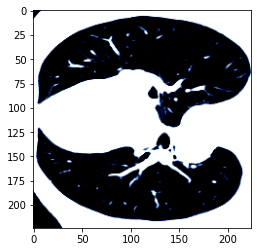

In [ ]:
print(sample_img.shape)
print(sample_label)
plt.imshow(sample_img.permute(2,1,0))

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
from torchvision import models

resnet18 = models.resnet18(pretrained=False)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet18 = models.resnet18(pretrained=False)
        num_ftrs = self.resnet18.fc.in_features
        self.resnet18.fc = torch.nn.Linear(num_ftrs, 1)
        for p in self.resnet18.parameters():
            p.requires_grad = True
            
    def get_trainable_params(self):
        pList = list(self.resnet18.parameters())
        return pList

    def forward(self, x):
        z = self.resnet18(x)
        z = z.view(-1)
        return z

In [ ]:
def save_checkpoint(filename, model, optimizer, result, epoch):
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'result':result},
               filename)
    print('saved:', filename)

In [ ]:
def train(model, device, optimizer, dataloader, epoch):    
    model.train()#set model to training mode
    loss_train=0
    acc_train =0 
    for batch_idx, (X, Y) in enumerate(dataloader):
        #print(X.shape, Y.shape)
        #print(X.dtype, Y.dtype)
        Y = Y.to(X.dtype)
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()#clear grad of each parameter
        Z = model(X)#forward pass
        loss = nnF.binary_cross_entropy_with_logits(Z, Y)
        loss.backward()#backward pass
        optimizer.step()#update parameters
        loss_train+=loss.item()        
        Yp = (Z.data > 0).to(torch.int64)
        Y = Y.to(torch.int64)
        acc_train+= torch.sum(Yp==Y).item()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{:.0f}%]\tLoss: {:.6f}'.format(
                    epoch, 100. * batch_idx / len(dataloader), loss.item()))
    loss_train/=len(dataloader)
    acc_train/=len(dataloader.dataset) 
    return loss_train, acc_train

In [ ]:
def test(model, device, dataloader):
    model.eval()#set model to evaluation mode
    loss_test=0
    acc_test =0
    Confusion=np.zeros((2,2))
    with torch.no_grad(): # tell Pytorch not to build graph in the with section
        for batch_idx, (X, Y) in enumerate(dataloader):     
            Y = Y.to(X.dtype)
            X, Y = X.to(device), Y.to(device)
            Z = model(X)#forward pass            
            loss = nnF.binary_cross_entropy_with_logits(Z, Y)
            loss_test+=loss.item()
            Yp = (Z.data > 0).to(torch.int64)
            Y = Y.to(torch.int64)
            acc_test+= torch.sum(Yp==Y).item()
            for i in range(0, 2):
                for j in range(0, 2):
                    Confusion[i,j]+=torch.sum((Y==i)&(Yp==j)).item()
    loss_test/=len(dataloader)        
    acc_test/=len(dataloader.dataset)
    Sens=np.zeros(2)
    Prec=np.zeros(2)   
    for n in range(0, 2):
        TP=Confusion[n,n]
        FN=np.sum(Confusion[n,:])-TP
        FP=np.sum(Confusion[:,n])-TP
        Sens[n]=TP/(TP+FN)
        Prec[n]=TP/(TP+FP)    
    Acc = Confusion.diagonal().sum()/Confusion.sum() # should be the same as acc_test
    return loss_test, acc_test, (Confusion, Acc, Sens, Prec)

In [ ]:
import torch.optim as optim

model = Net()
model.to(device)
optimizer = optim.AdamW(model.get_trainable_params(), lr=0.0001)

In [ ]:
(x,label)=dataset_train[0]
x=x.view(1,3,224,224).to(device)
z=model(x)

In [ ]:
loss_train_list=[]
acc_train_list=[]
loss_val_list=[]
acc_val_list=[]
epoch_save=-1

In [ ]:
y_hat = torch.sigmoid(z)
y_hat

tensor([0.4820], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [ ]:
z.size()

torch.Size([1])

In [ ]:
def plot_result(loss_train_list, acc_train_list, 
                loss_val_list, acc_val_list):    
    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    ax[0].set_title('loss v.s. epoch',fontsize=16)
    ax[0].plot(loss_train_list, '-b', label='training loss')
    ax[0].plot(loss_val_list, '-g', label='validation loss')
    ax[0].set_xlabel('epoch',fontsize=16)
    #ax[0].set_xticks(np.arange(len(loss_train_list)))
    ax[0].legend(fontsize=16)
    ax[0].grid(True)
    ax[1].set_title('accuracy v.s. epoch',fontsize=16)
    ax[1].plot(acc_train_list, '-b', label='training accuracy')
    ax[1].plot(acc_val_list, '-g', label='validation accuracy')
    ax[1].set_xlabel('epoch',fontsize=16)
    #ax[1].set_xticks(np.arange(len(loss_train_list)))
    ax[1].legend(fontsize=16)
    ax[1].grid(True)
    return fig, ax

In [ ]:
lr_new=0.0001
for g in optimizer.param_groups:
    g['lr']=lr_new

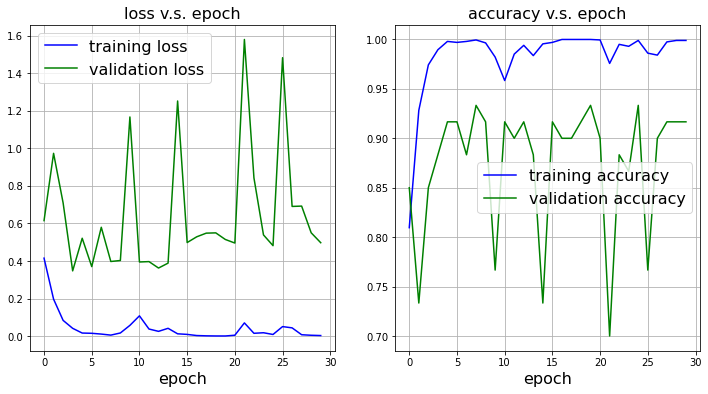

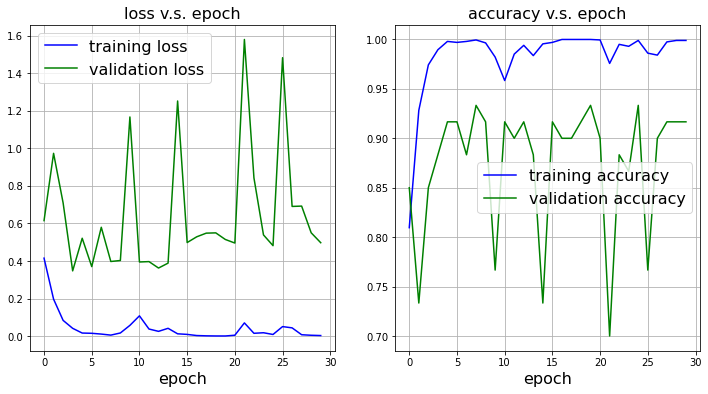

In [ ]:
for epoch in range(epoch_save+1, 30):
    #-------- training --------------------------------
    loss_train, acc_train =train(model, device, optimizer, loader_train, epoch)    
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train)
    #-------- validation --------------------------------
    loss_val, acc_val, other_val = test(model, device, loader_val)
    loss_val_list.append(loss_val)
    acc_val_list.append(acc_val)
    print('epoch', epoch, 'validation loss:', loss_val, 'acc:', acc_val)   
    #--------save model-------------------------
    result = (loss_train_list, acc_train_list, 
              loss_val_list, acc_val_list, other_val)
    save_checkpoint('Scratch_CNN_TL_Pytorch_epoch'+str(epoch)+'.pt', model, optimizer, result, epoch)
    epoch_save=epoch
    #------- show result ----------------------
    display.clear_output(wait=False)
    plt.close('all')
    fig, ax = plot_result(loss_train_list, acc_train_list, 
                          loss_val_list, acc_val_list)
    display.display(fig)

(<Figure size 864x432 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7efc5abf6ad0>,
       dtype=object))

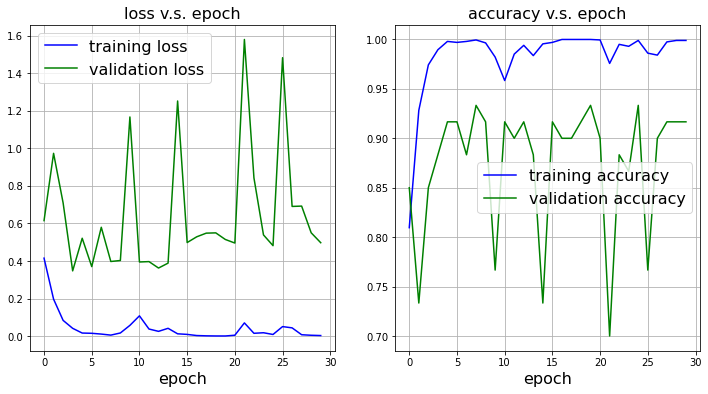

In [ ]:
plot_result(loss_train_list, acc_train_list, 
            loss_val_list, acc_val_list)

In [ ]:
best_id= np.array(acc_val_list).argmax()
best_id

7

In [ ]:
epoch_save=best_id
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
checkpoint=torch.load('Scratch_CNN_TL_Pytorch_epoch'+str(epoch_save)+'.pt', map_location=device)
model=Net()
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval() 
#
optimizer = optim.AdamW(model.get_trainable_params(), lr=0.0001)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#
(loss_train_list, acc_train_list, 
 loss_val_list, acc_val_list, other_val) = checkpoint['result'] 

In [ ]:
loss_val, acc_val, (Confusion, Acc, Sens, Prec) = test(model, device, loader_test)
Confusion_sens=Confusion.copy()
for n in range(0, 2):
    Confusion_sens[n,:]/=np.sum(Confusion[n,:])
Confusion_prec=Confusion.copy()
for n in range(0, 2):
    Confusion_prec[:,n]/=np.sum(Confusion[:,n])
print('Accuracy (average)', acc_val)
print('Accuracy (average)', Acc)
print('Sensitivity', Sens)
print('Precision', Prec)
print('Confusion_sens \n', Confusion_sens)
print('Confusion_prec \n', Confusion_prec)

Accuracy (average) 0.94
Accuracy (average) 0.94
Sensitivity [0.955 0.925]
Precision [0.92718447 0.95360825]
Confusion_sens 
 [[0.955 0.045]
 [0.075 0.925]]
Confusion_prec 
 [[0.92718447 0.04639175]
 [0.07281553 0.95360825]]
